# Clustering Toronto Neighborhoods

The purpose of this notebook is to cluster neghborhoods in Toronto based on type of venues in area.
The general plan for this project is as follows:
1. Scrape Toronto neighborhood information from [here](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M).
2. Gather geographical coordinates of neighborhoods using pgeocode.
3. Obtain venue information via Foursquare API.
4. Process Toronto data for K-Means analysis by obtaining the mean number of venues for each neighborhood.
5. Determine optimal number of clusters via elbow analysis.
6. Run K-Means.
7. Visualize and analyze.

## 0. Importing required libraries

In [1]:
# The basics
import re
import numpy as np
import pandas as pd

# For webscraping
import requests
from bs4 import BeautifulSoup as bs

# For getting geo coordinates
import pgeocode

# For plotting and visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library

# For K-Means modelling
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

## 1. Gathering Toronto neighborhood data

The following code is for the first part of the assignment where a pandas dataframe of Toronto neighborhood data is constructed

### a. Set up webscraping and soup

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(url)
soup = bs(r.text, 'html5lib') # hrml5lib is slow but easier to manage

### b. Exploring the soup

Finding the target table

In [3]:
tb = soup.find('table') # Isolate target table
print(tb.prettify())

<table cellpadding="2" cellspacing="0" rules="all" style="width:100%; border-collapse:collapse; border:1px solid #ccc;">
 <tbody>
  <tr>
   <td style="width:11%; vertical-align:top; color:#ccc;">
    <p>
     <b>
      M1A
     </b>
     <br/>
     <span style="font-size:85%;">
      <i>
       Not assigned
      </i>
     </span>
    </p>
   </td>
   <td style="width:11%; vertical-align:top; color:#ccc;">
    <p>
     <b>
      M2A
     </b>
     <br/>
     <span style="font-size:85%;">
      <i>
       Not assigned
      </i>
     </span>
    </p>
   </td>
   <td style="width:11%; vertical-align:top;">
    <p>
     <b>
      M3A
     </b>
     <br/>
     <span style="font-size:85%;">
      <a href="/wiki/North_York" title="North York">
       North York
      </a>
      <br/>
      (
      <a href="/wiki/Parkwoods" title="Parkwoods">
       Parkwoods
      </a>
      )
     </span>
    </p>
   </td>
   <td style="width:11%; vertical-align:top;">
    <p>
     <b>
      M4A
     </b>
 

In [4]:
print('The width of our table is',len(tb.find_all('tr')),'rows')
print('The length of our table is',len(soup.find('table').find('tr').find_all('td')),'columns')

The width of our table is 20 rows
The length of our table is 9 columns


Looking at the structure of the table above we can summize there are 20 rows, and 9 columns to extract. The postcode for each entry is under the 'b' tag, while borough and neighborhood are under 'span'. In cases where postcode is not assigned, the 'i' tag can be found followed by text 'Not assigned'. Will need a way to seperate text under 'span' tag from rest.

### c. Performing initial tests

In [5]:
# 1st row, and 4th column is first instance of fully populated cell
soup.find('table').find('tr').find_all('td')[4].get_text() # All required output are here; Need to seperate

'\nM5ADowntown Toronto(Regent Park / Harbourfront)\n\n'

In [6]:
soup.find('table').find('tr').find_all('td')[4].find('span').get_text()
# Borough and neighborhood are located inside same cell as a single string; Need seperation

'Downtown Toronto(Regent Park / Harbourfront)'

### d. Extracting data and constructing dataframe

In [7]:
# Create dataframe with headers
df =  pd.DataFrame({'Postal Code':[], 'Borough':[], 'Neighborhood':[]})

for r in tb.find_all('tr'): # Loop through all rows
    for c in r.find_all('td'): # Loop through all columns
        if c.find('a') != None: # Skip empty cells
            Code = c.find('b').get_text() # Store postcode here
            Text = c.find('span').get_text().replace('/',',') # Replace '/' in 'span' tag with ','
            Borough = re.search(r'(.*?)\(', Text).group(1) # Seperate Borough from text output
            Neighborhood = re.search(r'\((.*?)\)', Text).group(1) # Seperate Neighborhood from text output
            app = pd.DataFrame({'Postal Code':[Code], 'Borough':[Borough], 'Neighborhood':[Neighborhood]})
            df = df.append(app,ignore_index=True)
            
df.head(10)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern , Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill , Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


This is the end of the first portion of the assignment. Wikipedia's page on Toronto has been scraped and the data reconstructed into a pandas dataframe.

## 2. Gathering geographic coordinates

This is the start of the second portion of the assignment where coordinates are gathered and merged with pandas dataframe of Toronto neighborhood

In [8]:
# Set up empty dataframe
Coordinates = pd.DataFrame({'latitude':[],'longitude':[]})
# Set country as Canada
nomi = pgeocode.Nominatim('ca')
# Loop calls
for index, row in df.iterrows():
    nomi_output = nomi.query_postal_code(row['Postal Code']) # Nominatim output(DataFrame)
    latlong = pd.DataFrame({'latitude':[nomi_output['latitude']],'longitude':[nomi_output['longitude']]})
    Coordinates = Coordinates.append(latlong,ignore_index=True)

In [9]:
df = pd.concat([df,Coordinates],axis=1)
df.head()

,Postal Code,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.7223,-79.4504
4,M7A,Queen's Park,Ontario Provincial Government,43.6641,-79.3889


This is the end of the second portion of the assignment. Coordinates for Toronto neighborhoods were gathered and merged with existing Toronto data.

## 3. Exploring and clustering neighborhoods in Toronto

This is the start of the third portion of the assignment where Toronto neighborhoods are analyzed, clustered, and visualized.

### a. Initial analysis and visualization of Toronto

Nominatim cannot find information on the following postcodes. Therefore, they will be dropped. The most likely reason for this is these postcodes are special administrative regions set up by the government which doesn't correlate to Nomatim's databases.

In [10]:
# Missing coordinates
df[df.isna().any(axis=1)]

,Postal Code,Borough,Neighborhood,latitude,longitude
74,M7R,MississaugaCanada Post Gateway Processing Centre,Enclave of L4W,NaN,NaN


It appears to be a mail processing center for Canada post that's been given its own postcode for administrative purposes.

In [11]:
nomi.query_postal_code(df['Postal Code'][74]) 

postal_code       M7R
country_code      NaN
place_name        NaN
state_name        NaN
state_code        NaN
county_name       NaN
county_code       NaN
community_name    NaN
community_code    NaN
latitude          NaN
longitude         NaN
accuracy          NaN
Name: 0, dtype: object

No information of this postcode exist within Nominatim's databases.

In [12]:
# Drop problematic postal code
df.dropna(inplace=True)
df.isna().sum()

Postal Code     0
Borough         0
Neighborhood    0
latitude        0
longitude       0
dtype: int64

In [13]:
# Create map of Toronto
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=10)
# add markers to map
for index, row in df.iterrows():
    label = '{}, {}'.format(row['Neighborhood'], row['Borough'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row['latitude'],row['longitude']],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### b. Gathering Foursquare data

In [14]:
# Defining cradentials
CLIENT_ID = 'AF4TCD4CRMYS1ZXLDAVXGZBEMUO2C2JENWLUQXQCYMIRMNHT' # your Foursquare ID
CLIENT_SECRET = 'QZJW3MLEUG0DV2GGCMCAZJTW53VYDAZYC0JOP1NMBBB2FWKR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AF4TCD4CRMYS1ZXLDAVXGZBEMUO2C2JENWLUQXQCYMIRMNHT
CLIENT_SECRET:QZJW3MLEUG0DV2GGCMCAZJTW53VYDAZYC0JOP1NMBBB2FWKR


#### Testing on first neighborhoods

In [15]:
neighborhood_name = df.loc[0, 'Neighborhood'] 
neighborhood_latitude = df.loc[0, 'latitude'] 
neighborhood_longitude = df.loc[0, 'longitude']

In [16]:
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7545, -79.33.


In [17]:
limit = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    limit)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=AF4TCD4CRMYS1ZXLDAVXGZBEMUO2C2JENWLUQXQCYMIRMNHT&client_secret=QZJW3MLEUG0DV2GGCMCAZJTW53VYDAZYC0JOP1NMBBB2FWKR&v=20180605&ll=43.7545,-79.33&radius=500&limit=100'

In [19]:
r = requests.get(url)
r.json()

{'meta': {'code': 200, 'requestId': '60514cdd705bdd2260f21e1b'},
 'response': {'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.7590000045, 'lng': -79.32378161085641},
   'sw': {'lat': 43.7499999955, 'lng': -79.33621838914358}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.751976046055574,
          'lng': -79.33214044722958}],
        'distance': 329,
        'cc': 'CA',
       

#### Retrieve data for all Toronto neighborhoods

In [20]:
# Build function to automate calls
def GetNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for index, row in df.iterrows():
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            row['latitude'], 
            row['longitude'], 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            row['Neighborhood'], 
            row['latitude'], 
            row['longitude'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
# Build Toronto venues data
Toronto_venues = GetNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude'])
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.7545,-79.3300,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.7545,-79.3300,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
2,Parkwoods,43.7545,-79.3300,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Parkwoods,43.7545,-79.3300,Brookbanks Pool,43.751389,-79.332184,Pool
4,Victoria Village,43.7276,-79.3148,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


In [22]:
Toronto_venues.shape

(2154, 7)

Foursquare returns 2,154 venues within the Toronto metropolitan area. It would be more efficient to view the data as grouped by each neighborhood.

In [23]:
# Group data by neighborhood
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood , Long Branch",6,6,6,6,6,6
"Bathurst Manor , Wilson Heights , Downsview North",6,6,6,6,6,6
Bayview Village,4,4,4,4,4,4
"Bedford Park , Lawrence Manor East",24,24,24,24,24,24
...,...,...,...,...,...,...
"Willowdale , Newtonbrook",2,2,2,2,2,2
Woburn,1,1,1,1,1,1
Woodbine Heights,5,5,5,5,5,5


In [24]:
# Unique Categories
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 254 uniques categories.


### C. Processing Foursquare Data

#### Creating dummy variables

In [25]:
# one hot encoding
Toronto_coding = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
Toronto_coding['Neighborhood'] = Toronto_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [Toronto_coding.columns[-1]] + list(Toronto_coding.columns[:-1])
Toronto_coding = Toronto_coding[fixed_columns]
print(Toronto_coding.shape)
Toronto_coding.head(10)

(2154, 254)


,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Grouping by neighborhoods

In [26]:
Toronto_grouped = Toronto_coding.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head(10)

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000
1,"Alderwood , Long Branch",0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000
2,"Bathurst Manor , Wilson Heights , Downsview North",0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000
3,Bayview Village,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000
4,"Bedford Park , Lawrence Manor East",0.000000,0.000,0.0,0.0,0.0,0.041667,0.000000,0.0,0.000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000
5,Berczy Park,0.010638,0.000,0.0,0.0,0.0,0.000000,0.021277,0.0,0.000,...,0.010638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000
6,"Birch Cliff , Cliffside West",0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000
7,"Brockton , Parkdale Village , Exhibition Place",0.025000,0.025,0.0,0.0,0.0,0.000000,0.025000,0.0,0.025,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000
8,"CN Tower , King and Spadina , Railway Lands , ...",0.017241,0.000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017241,0.000
9,Caledonia-Fairbanks,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125


#### Analyzing each neighborhood by 10 most common venues

In [27]:
# Build function to transform data
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Newsagent,Badminton Court,Latin American Restaurant,Skating Rink,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market
1,"Alderwood , Long Branch",Convenience Store,Pub,Pizza Place,Sandwich Place,Coffee Shop,Gym,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room
2,"Bathurst Manor , Wilson Heights , Downsview North",Fried Chicken Joint,Pizza Place,Mediterranean Restaurant,Middle Eastern Restaurant,Deli / Bodega,Coffee Shop,Falafel Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant
3,Bayview Village,Flower Shop,Park,Gas Station,Trail,Women's Store,Ethiopian Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Event Space
4,"Bedford Park , Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Pharmacy,Thai Restaurant,Comfort Food Restaurant,Pizza Place,Pub,Restaurant,Café
5,Berczy Park,Coffee Shop,Bakery,Café,Seafood Restaurant,Hotel,Cocktail Bar,Restaurant,Beer Bar,Japanese Restaurant,Art Gallery
6,"Birch Cliff , Cliffside West",General Entertainment,Café,Skating Rink,College Stadium,Women's Store,Event Space,Electronics Store,Escape Room,Ethiopian Restaurant,Farmers Market
7,"Brockton , Parkdale Village , Exhibition Place",Café,Coffee Shop,Gift Shop,Breakfast Spot,Thrift / Vintage Store,Yoga Studio,Boutique,French Restaurant,Brewery,Liquor Store
8,"CN Tower , King and Spadina , Railway Lands , ...",Coffee Shop,Italian Restaurant,Café,Bar,Gym / Fitness Center,Bakery,Speakeasy,French Restaurant,Park,Bank
9,Caledonia-Fairbanks,Park,Women's Store,Mexican Restaurant,Gym,Bakery,Beer Store,Sporting Goods Shop,Field,Fast Food Restaurant,Fish & Chips Shop


### D. Clustering neighborhoods

In [29]:
# Build dataset for clustering
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

#### Determining obtimal number of clusters

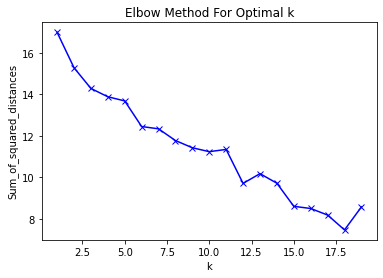

In [31]:
# Elbow analysis
Sum_of_squared_distances = []
range_n_clusters = range(1,20) # Test upto 20 clusters
for k in range_n_clusters:
    km = KMeans(n_clusters=k,init='random',algorithm='full').fit(Toronto_grouped_clustering) # Random initialization and full algorithm: More resource intensive but better for undefined clusters
    Sum_of_squared_distances.append(km.inertia_)

# Build elbow plot
plt.plot(range_n_clusters, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow method doesn't provide for an optimal number of clusters. Based on the shape of the line, a sillouhette analysis would likely generate the same conclusion. The analysis suggest that there are no well-defined clusters within the dataset. Looking back at the dataset, there are some possible reasons:
1. There are no well-defined clusters withinin the dataset.
2. The dataset is heavily skewed towards a particular venue

Regardless, for the purposes of this assignment, the optimal number of clusters will be assumed at 3. This is because based on overall shape, this may be the point before the skew of the dataset interferes with the k-means algorithm.

#### Running K-Means

In [32]:
# set number of clusters
kclusters = 3
# run k-means clustering
KM_final = KMeans(n_clusters=kclusters,init='random',algorithm='full',verbose=1).fit(Toronto_grouped_clustering)

Initialization complete
Iteration 0, inertia 25.712204615645803.
Iteration 1, inertia 15.57461702733504.
Iteration 2, inertia 15.248839235315373.
Iteration 3, inertia 15.060648700624174.
Iteration 4, inertia 14.949668397715875.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 17.99556968191546.
Iteration 1, inertia 15.420682088061614.
Iteration 2, inertia 15.038249095891722.
Iteration 3, inertia 14.943647612982005.
Iteration 4, inertia 14.906427529867845.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 25.30366860134886.
Iteration 1, inertia 15.310063034186317.
Iteration 2, inertia 15.117522634090351.
Iteration 3, inertia 15.026703210597928.
Iteration 4, inertia 14.902621095933096.
Iteration 5, inertia 14.845646740830992.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 19.13640137238966.
Iteration 1, inertia 16.389070326035394.
Iteration 2, inertia 16.34459752

The verbose output of K-Means confirms that the dataset has any well-defined clusters.

#### Visualizing results

In [33]:
# Merge clustering labels
neighborhoods_venues_sorted.insert(0,'Cluster Labels',KM_final.labels_)
Toronto_merged = df
# Joins the two table based on neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged.head(10) 

,Postal Code,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.7545,-79.3300,1.0,Food & Drink Shop,Park,Pool,Bus Stop,Event Space,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Farmers Market
1,M4A,North York,Victoria Village,43.7276,-79.3148,2.0,Hockey Arena,Pizza Place,Park,Intersection,Portuguese Restaurant,Coffee Shop,French Restaurant,Women's Store,Ethiopian Restaurant,Dumpling Restaurant
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.6555,-79.3626,2.0,Coffee Shop,Breakfast Spot,Restaurant,Yoga Studio,Spa,Food Truck,Event Space,Beer Store,Electronics Store,Bakery
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.7223,-79.4504,2.0,Clothing Store,Coffee Shop,Women's Store,Restaurant,Cosmetics Shop,Toy / Game Store,Sandwich Place,Men's Store,Food Court,Juice Bar
4,M7A,Queen's Park,Ontario Provincial Government,43.6641,-79.3889,2.0,Sushi Restaurant,Italian Restaurant,Creperie,College Theater,Bubble Tea Shop,Café,Mexican Restaurant,Ethiopian Restaurant,Escape Room,Beer Bar
5,M9A,Etobicoke,Islington Avenue,43.6662,-79.5282,1.0,Pharmacy,Park,Grocery Store,Skating Rink,Bank,Fast Food Restaurant,Field,Farmers Market,Donut Shop,Event Space
6,M1B,Scarborough,"Malvern , Rouge",43.8113,-79.1930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,M3B,North York,Don Mills,43.7450,-79.3590,1.0,River,Park,Pool,Trail,Gym,Women's Store,Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.7063,-79.3094,2.0,Pizza Place,Pet Store,Gym / Fitness Center,Pharmacy,Café,Gastropub,Bank,Flea Market,Intersection,Curling Ice
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783,2.0,Coffee Shop,Clothing Store,Italian Restaurant,Hotel,Middle Eastern Restaurant,Café,Japanese Restaurant,Cosmetics Shop,Movie Theater,Theater


In [34]:
# Missing values in final dataset from lack of recognized venues
Toronto_merged.isna().sum()

Postal Code               0
Borough                   0
Neighborhood              0
latitude                  0
longitude                 0
Cluster Labels            3
1st Most Common Venue     3
2nd Most Common Venue     3
3rd Most Common Venue     3
4th Most Common Venue     3
5th Most Common Venue     3
6th Most Common Venue     3
7th Most Common Venue     3
8th Most Common Venue     3
9th Most Common Venue     3
10th Most Common Venue    3
dtype: int64

Some neighborhoods appear to not have any venues recognized by Foursquare

In [35]:
# Removing empty neighborhoods
Toronto_merged.dropna(inplace=True)

In [36]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for index, row in Toronto_merged.iterrows():
    label = folium.Popup(str(row['Neighborhood'])+str(row['Cluster Labels'])+str(row['Cluster Labels']),parse_html=True)
    folium.CircleMarker(
        [row['latitude'], row['longitude']],
        radius=5,
        popup=label,
        color=rainbow[int(row['Cluster Labels'])-1],
        fill=True,
        fill_color=rainbow[int(row['Cluster Labels'])-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### E. Exploring each cluster

In [37]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,East Toronto,0.0,Pub,Asian Restaurant,Health Food Store,Gastropub,Trail,Bakery,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
49,North York,0.0,Bakery,Trail,Basketball Court,Falafel Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Women's Store,Eastern European Restaurant
52,North York,0.0,Playground,Electronics Store,Women's Store,Donut Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
63,Scarborough,0.0,Bakery,Asian Restaurant,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Women's Store,Dumpling Restaurant


In [38]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,1.0,Food & Drink Shop,Park,Pool,Bus Stop,Event Space,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Farmers Market
5,Etobicoke,1.0,Pharmacy,Park,Grocery Store,Skating Rink,Bank,Fast Food Restaurant,Field,Farmers Market,Donut Shop,Event Space
7,North York,1.0,River,Park,Pool,Trail,Gym,Women's Store,Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
13,North York,1.0,River,Park,Pool,Trail,Gym,Women's Store,Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
16,York,1.0,Grocery Store,Hockey Arena,Field,Playground,Park,Deli / Bodega,Trail,Women's Store,Dumpling Restaurant,Eastern European Restaurant
21,York,1.0,Park,Women's Store,Mexican Restaurant,Gym,Bakery,Beer Store,Sporting Goods Shop,Field,Fast Food Restaurant,Fish & Chips Shop
27,North York,1.0,Park,Residential Building (Apartment / Condo),Women's Store,Event Space,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Falafel Restaurant
32,Scarborough,1.0,Spa,Park,Grocery Store,Event Space,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Women's Store
35,East YorkEast Toronto,1.0,Park,Intersection,Convenience Store,Greek Restaurant,Women's Store,Event Space,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant
36,Downtown Toronto,1.0,Harbor / Marina,Music Venue,Café,Park,Event Space,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Women's Store


In [39]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,2.0,Hockey Arena,Pizza Place,Park,Intersection,Portuguese Restaurant,Coffee Shop,French Restaurant,Women's Store,Ethiopian Restaurant,Dumpling Restaurant
2,Downtown Toronto,2.0,Coffee Shop,Breakfast Spot,Restaurant,Yoga Studio,Spa,Food Truck,Event Space,Beer Store,Electronics Store,Bakery
3,North York,2.0,Clothing Store,Coffee Shop,Women's Store,Restaurant,Cosmetics Shop,Toy / Game Store,Sandwich Place,Men's Store,Food Court,Juice Bar
4,Queen's Park,2.0,Sushi Restaurant,Italian Restaurant,Creperie,College Theater,Bubble Tea Shop,Café,Mexican Restaurant,Ethiopian Restaurant,Escape Room,Beer Bar
8,East York,2.0,Pizza Place,Pet Store,Gym / Fitness Center,Pharmacy,Café,Gastropub,Bank,Flea Market,Intersection,Curling Ice
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Downtown Toronto,2.0,Coffee Shop,Hotel,Café,Restaurant,Gym,Salad Place,American Restaurant,Japanese Restaurant,Seafood Restaurant,Deli / Bodega
96,Etobicoke,2.0,Breakfast Spot,Bank,Sushi Restaurant,Bakery,Bar,Boutique,Restaurant,Burger Joint,Coffee Shop,Liquor Store
97,Downtown Toronto,2.0,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Gay Bar,Restaurant,Grocery Store,Hotel,Fast Food Restaurant,Diner,Mediterranean Restaurant
98,East TorontoBusiness reply mail Processing Cen...,2.0,Restaurant,Coffee Shop,Italian Restaurant,Yoga Studio,Intersection,Bank,Martial Arts School,Sushi Restaurant,Japanese Restaurant,Bookstore


This is the end of the third portion of the assignment. Although there does not seem, to be any well defined clusters within the dataset, Toronto has been partitioned into 3 clusters based on the number of venues in each neighborhood.